Задание: <br><br>
В рамках этого проекта вы будете работать над пониманием результатов A/B-теста, проведенного веб-сайтом электронной коммерции. Компания разработала новую веб-страницу с целью увеличения **количества пользователей, которые "конвертируют"**, то есть пользователей, которые решают заплатить за продукт компании. Ваша цель - поработать с этим блокнотом, чтобы помочь компании понять, следует ли им внедрить новую страницу, сохранить старую или, возможно, продлить эксперимент, чтобы принять решение.

#0. Загрузка необходимых библиотек

In [ ]:
!pip install bootstrapped

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from bootstrapped import bootstrap as bs
from bootstrapped import compare_functions as bs_compare
from bootstrapped import stats_functions as bs_stats

#1. Изучение общей информации о данных

Загружаем данные:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

data = pd.read_csv('gdrive/MyDrive/Colab Notebooks/e_commerce_data/ab_test.csv')
countries = pd.read_csv('gdrive/MyDrive/Colab Notebooks/e_commerce_data/countries_ab.csv')

Mounted at /content/gdrive


Выводим общую информацию о таблице data:

In [ ]:
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         294478 non-null  int64 
 1   time       294478 non-null  object
 2   con_treat  294478 non-null  object
 3   page       294478 non-null  object
 4   converted  294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


Мы сразу можем заметить, что в таблице нет пропусков (null)

Изменяем название столбца con_treat для лучшей читабельности информации о данных:

In [ ]:
data = data.rename(columns={'con_treat':'group'})
data.head()

,id,time,group,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


Выводим общую информацию о таблице countries:

In [ ]:
countries.info()
countries.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       290584 non-null  int64 
 1   country  290584 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


,id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


Мы сразу можем заметить, что в таблице нет пропусков (null)

В таблице представлены данные о пользователях из трех стран: США (US), Великобритании (UK) и Канады (UK)

In [ ]:
countries['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

**Информация о данных:** <br>
Количество записей в таблице data - 294478, в таблице countries - 290584. <br>
Поля: <br>
- id - уникальный идентификатор пользователя
- time - общее время, проведенное на странице
- group - группа, к которой был отнесен пользователь (тестовая или контрольная)
- page - вариант страницы, показываемый пользователю (старый или новый)
- converted - решение пользователя заплатить за продукт (да или нет)
- country - страна (UK, US, CA)


#2. Предобработка данных

Пропусков (null) в данных нет, что мы заметили в предыдущем пункте

Количества записей в таблицах data и users различаются, хотя таблицы и связаны полем 'id'. Посмотрим, сколько уникальных id в каждой таблице:

In [ ]:
print('Number of unique IDs in the \'data\' table:', data['id'].nunique())
print('Number of unique IDs in the \'countries\' table:', countries['id'].nunique())

Number of unique IDs in the 'data' table: 290584
Number of unique IDs in the 'countries' table: 290584


Количества уникальных id в таблицах совпадают. <br>
Стоит разобраться с дубликатами id в таблице data, т.к. вся информация о конкретном пользователе хранится в записи с его идентификатором (в том числе, если пользователь несколько раз заходил на сайт, время, проведенное им на сайте, суммируется, а converted становится равным 1, если пользователь хотя бы в одном посещении решил заплатить за продукт)

In [ ]:
counts = data.groupby('id').size()
duplicates = pd.DataFrame(counts, columns = ['size'])
duplicates = duplicates.loc[duplicates['size'] > 1]

In [ ]:
duplicates_df = data.loc[data['id'].isin(duplicates.index)].sort_values('id')
duplicates_df.head(10)

,id,time,group,page,converted
230259,630052,16:05.2,treatment,new_page,0
213114,630052,25:54.1,treatment,old_page,1
22513,630126,35:54.8,treatment,old_page,0
251762,630126,16:00.3,treatment,new_page,0
183371,630137,08:49.9,control,old_page,0
11792,630137,59:22.1,control,new_page,0
207211,630320,02:43.6,control,old_page,0
255753,630320,27:37.2,treatment,old_page,0
96929,630471,14:17.4,control,new_page,0
110634,630471,42:51.5,control,old_page,0


В таблице дубликатов заметна странная ситуация: для одного и того же id различаются ['group', 'page'], т.е. при одной и той же группе могут быть разные страницы, и наоборот. <br>
Согласно сути эксперимента, между столбцами 'group' и 'page' должно быть однозначное соответствие: пользователям, отнесенным к контрольной выборке, показывается старый вариант страницы, пользователям, отнесенным к тестовой - новый. <br>
Вероятно, записи с ('group' = 'control', 'page' = 'new_page') или ('group' = 'treatment', 'page' = 'old_page') были занесены в таблицу ошибочно, либо произошла ошибка при сплитовании пользователей.

Так как затруднительно сказать, в какую сторону произошла ошибка (например, какое поле корректно при ситуации 'group' = 'control', 'page' = 'new_page'), мы не будем работать с ошибочными полями и удалим их из таблицы.

In [ ]:
data = data.loc[(data['group'] == 'control') & (data['page'] == 'old_page') |
                (data['group'] == 'treatment') & (data['page'] == 'new_page')]
data

,id,time,group,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1
...,...,...,...,...,...
294473,751197,28:38.6,control,old_page,0
294474,945152,51:57.1,control,old_page,0
294475,734608,45:03.4,control,old_page,0
294476,697314,20:29.0,control,old_page,0


Насколько мы помним, количество уникальных id в таблице - 290584, что на 1 меньше нового размера таблицы. Найдем оставшийся дубликат и удалим его.

In [ ]:
data.loc[data.duplicated('id') == True]

,id,time,group,page,converted
2893,773192,55:59.6,treatment,new_page,0


In [ ]:
data = data.drop_duplicates('id')

Напоследок объединим таблицы data и countries на основе id пользователей

In [ ]:
data = data.merge(countries, on='id')
data.head()

,id,time,group,page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US


#3. A/B тест

Сравним размеры выборок:

In [ ]:
size_a = data.loc[data['group'] == 'control'].shape[0]
size_b = data.loc[data['group'] == 'treatment'].shape[0]

print('Control group size:', size_a)
print('Treatment group size:', size_b)
print('Difference in sizes:', abs(size_b - size_a))

Control group size: 145274
Treatment group size: 145310
Difference in sizes: 36


Размеры выборок приблизительно равны (разница между ними 36, что очень мало по отношению к объемам выборок)

Выделим контрольную и тестовую группу в отдельные таблицы для дальнейшего удобства работы с ними:

In [ ]:
group_a = data.loc[data['group'] == 'control']
group_b = data.loc[data['group'] == 'treatment']

##Converted

In [ ]:
converted_a = group_a['converted']
converted_b = group_b['converted']

sum_converted_a = converted_a.sum()
sum_converted_b = converted_b.sum()

In [ ]:
total_lift = round(((sum_converted_b / size_b) / (sum_converted_a / size_a) - 1) * 100, 2)

print('Control group converted: {:.2f}%'.format(sum_converted_a / size_a * 100))
print('Treatment group converted: {:.2f}%'.format(sum_converted_b / size_b * 100))
print('Lift: {:.2f}%'.format(total_lift))

Control group converted: 12.04%
Treatment group converted: 11.88%
Lift: -1.31%


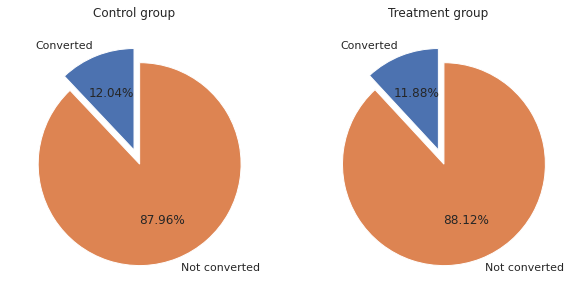

In [ ]:
fig, ax = plt.subplots(1, 2)

ax[0].pie([sum_converted_a, converted_a.shape[0] - sum_converted_a], 
        explode=[0.0, 0.15], labels=['Converted', 'Not converted'], 
        autopct='%1.2f%%', shadow=False, startangle=90)
ax[0].set_title('Control group')

ax[1].pie([sum_converted_b, converted_b.shape[0] - sum_converted_b], 
        explode=[0.0, 0.15], labels=['Converted', 'Not converted'], 
        autopct='%1.2f%%', shadow=False, startangle=90)
ax[1].set_title('Treatment group')

plt.show()

Процент converted уменьшился в тестовой группе по сравнению с контрольной, но на достаточно малое значение. Очень вероятно, что это изменение вызвано случайными причинами и статически не значимо, однако необходимо это проверить. <br><br>
Введем две гипотезы: <br>
**H0** - различия между долями converted для контрольной и тестовой групп вызваны лишь случайными причинами <br>
**H1** - между долями converted для контрольной и тестовой групп действительно существуют значимые различия

Распределения (Бернулли):

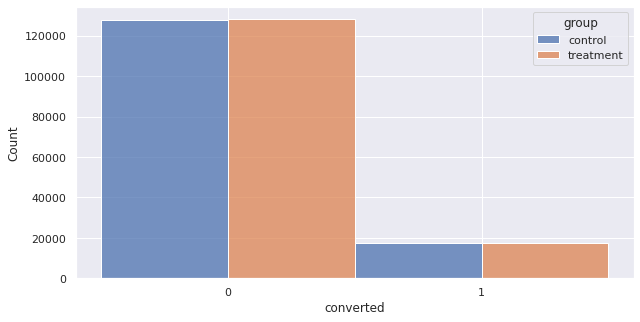

In [ ]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(10, 5)})

sns.histplot(data=data, hue='group', x='converted', 
             discrete=True, multiple='dodge')
plt.xticks([0, 1])

plt.show()

###Двухвыборочный Z-Тест для пропорций (долей) в модели Бернулли

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05

p_value = proportions_ztest(count=[sum_converted_a, sum_converted_b], 
                            nobs=[size_a, size_b])[1]
 
print('Diff is {}significant (p-value = {:.2f})'.
      format({False:'not ', True:''}[p_value < alpha], p_value)) 

Diff is not significant (p-value = 0.19)


На основе Z-теста мы **не можем отвергнуть нулевую гипотезу**, утверждающую, что между конверсиями пользователей для контрольной и тестовой групп нет различий или есть небольшие различия, вызванные лишь случайными причинами.

###Bootstrap

Покажем приблизительные распределения значений, получаемые из наших исходных выборок при помощи метода bootstrap

In [ ]:
converted_bs_a = bs.bootstrap(np.array(converted_a),
                              stat_func=bs_stats.mean, num_iterations=1000,
                              iteration_batch_size=100,
                              return_distribution=True)
converted_bs_b = bs.bootstrap(np.array(converted_b),
                              stat_func=bs_stats.mean, num_iterations=1000,
                              iteration_batch_size=100,
                              return_distribution=True)

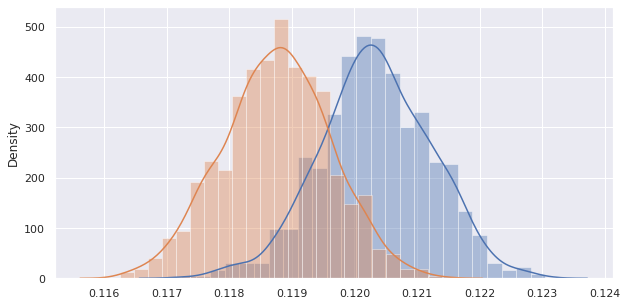

In [ ]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(10, 5)})

sns.distplot(converted_bs_a)
sns.distplot(converted_bs_b, color='#de8551')

plt.show()

Производим оценку статистической значимости различий с помощью встроенной функции bootstrap_ab 

In [ ]:
converted_bs = bs.bootstrap_ab(np.array(converted_b), np.array(converted_a),
                               bs_stats.mean, bs_compare.percent_change, 
                               num_iterations=1000, iteration_batch_size=100, 
                               alpha=0.05, scale_test_by=1, num_threads=4)

#confidence interval
ci = converted_bs

if ci.lower_bound < 0 < ci.upper_bound:
  print('Diff is not significant (confidence interval ({:.2f}, {:.2f}) contains 0)'.
        format(ci.lower_bound, ci.upper_bound)) 
else:
  print('Diff is significant (confidence interval ({:.2f}, {:.2f}) doesn\'t contain 0)'.
        format(ci.lower_bound, ci.upper_bound))

Diff is not significant (confidence interval (-3.25, 0.61) contains 0)


Bootstrap подтверждает полученный с помощью Z-теста вывод: мы **не можем отвергнуть нулевую гипотезу**.

##Converted through countries

Рассмотрим изменение converted users для каждой страны в отдельности

In [ ]:
converted_uk = data.loc[data['country'] == 'UK'][['converted', 'group']]
converted_us = data.loc[data['country'] == 'US'][['converted', 'group']]
converted_ca = data.loc[data['country'] == 'CA'][['converted', 'group']]

print('UK users: {} ({} : {})'.format(converted_uk.shape[0], 
      converted_uk.loc[converted_uk['group'] == 'control'].shape[0],
      converted_uk.loc[converted_uk['group'] == 'treatment'].shape[0]))
print('US users: {} ({} : {})'.format(converted_us.shape[0],
      converted_us.loc[converted_us['group'] == 'control'].shape[0],
      converted_us.loc[converted_us['group'] == 'treatment'].shape[0]))
print('CA users: {} ({} : {})'.format(converted_ca.shape[0], 
      converted_ca.loc[converted_ca['group'] == 'control'].shape[0],
      converted_ca.loc[converted_ca['group'] == 'treatment'].shape[0]))

UK users: 72466 (36360 : 36106)
US users: 203619 (101716 : 101903)
CA users: 14499 (7198 : 7301)


Как мы можем заметить, больше всего пользователей, заходивших на сайт, были из США, меньше всего - из Канады

Оценим визуально изменения в долях converted users, а также рассчитаем lift для каждой страны

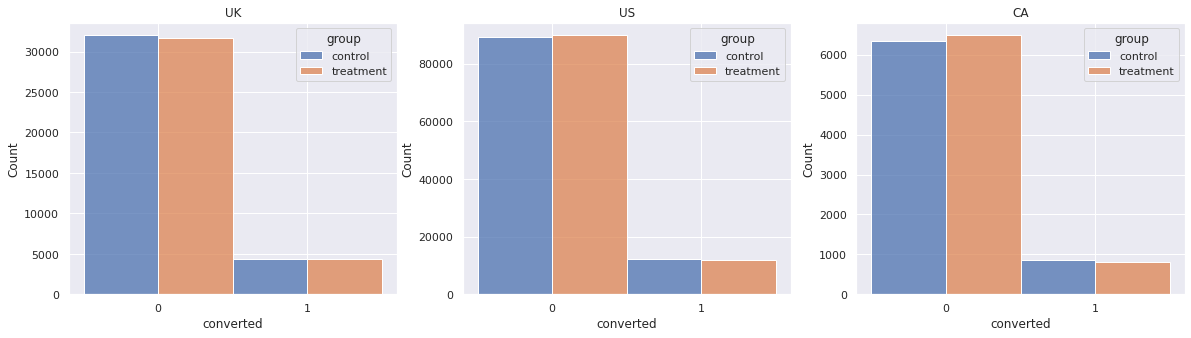

In [ ]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(20, 5)})
fig, ax = plt.subplots(1, 3)

sns.histplot(data=converted_uk, hue='group', hue_order=['control', 'treatment'], 
             x='converted', discrete=True, multiple='dodge', ax=ax[0])
plt.xticks([0, 1])
ax[0].set_title('UK')

sns.histplot(data=converted_us, hue='group', hue_order=['control', 'treatment'],
             x='converted', discrete=True, multiple='dodge', ax=ax[1])
plt.xticks([0, 1])
ax[1].set_title('US')

sns.histplot(data=converted_ca, hue='group', hue_order=['control', 'treatment'],
             x='converted', discrete=True, multiple='dodge', ax=ax[2])
plt.xticks([0, 1])
ax[2].set_title('CA')

plt.setp(ax, xticks=[0, 1])
plt.show()

In [ ]:
def percent(df, group):

  sum = df.loc[df['group'] == group]['converted'].sum()
  size = df.loc[df['group'] == group]['converted'].shape[0]

  return sum / size

conv_countries = [converted_uk, converted_us, converted_ca]
names = ['UK', 'US', 'CA']

d = {}
j = 0

for i in conv_countries:
  values = []
  values.append(round(percent(i, 'control') * 100, 2))
  values.append(round(percent(i, 'treatment') * 100, 2))
  values.append(round((percent(i, 'treatment') / percent(i, 'control') - 1) * 100, 2))
  d[names[j]] = pd.Series(values, 
                      index=['control_converted', 'treatment_converted', 'lift'])
  j += 1
  
country_lift = pd.DataFrame(d)
country_lift

,UK,US,CA
control_converted,12.00,12.06,11.88
treatment_converted,12.12,11.85,11.19
lift,0.96,-1.79,-5.79


Изменения в долях converted для Великобритании и США достаточно малы, но для Канады мы видим уменьшение почти на 6%. Разумеется, какие-либо выводы делать пока рано: необходимо проверить статистическую значимость этих изменений


Две гипотезы аналогичны тем, что мы вводили ранее, но проверяются для каждой страны в отдельности <br>
**H0** - раличия между долями converted для контрольной и тестовой групп вызваны лишь случайными причинами <br>
**H1** - между долями converted для контрольной и тестовой групп действительно существуют значимые различия

###Двухвыборочный Z-Тест для пропорций (долей) в модели Бернулли

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05

def z_test(df):

  sum_a = df.loc[df['group'] == 'control']['converted'].sum()
  sum_b = df.loc[df['group'] == 'treatment']['converted'].sum()
  size_a = df.loc[df['group'] == 'control']['converted'].shape[0]
  size_b = df.loc[df['group'] == 'treatment']['converted'].shape[0]

  p_value = proportions_ztest(count=[sum_a, sum_b], 
                              nobs=[size_a, size_b])[1]
 
  print('Diff is {}significant (p-value = {:.2f})'.
        format({False:'not ', True:''}[p_value < alpha], p_value)) 

print('UK: ', end='')
z_test(converted_uk)
print('US: ', end='')
z_test(converted_us)
print('CA: ', end='')
z_test(converted_ca)

UK: Diff is not significant (p-value = 0.63)
US: Diff is not significant (p-value = 0.13)
CA: Diff is not significant (p-value = 0.19)


На основе Z-теста мы **не можем отвергнуть нулевую гипотезу**, утверждающую, что между долями converted для контрольной и тестовой групп нет различий, ни для одной из стран

#4. Необходимый объем выборки

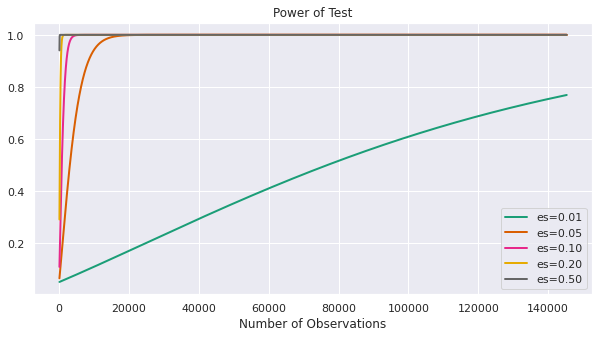

In [ ]:
from statsmodels.stats.power import TTestIndPower

analysis = TTestIndPower()
analysis.plot_power(nobs=np.arange(100, 145300), 
                    effect_size=np.array([0.01, 0.05, 0.1, 0.2, 0.5])) 

plt.show()

Для обнаружения малых эффектов (а именно такие мы и получили в процессе анализа) объемов наших выборок более, чем достаточно

#5. Заключение

Обобщим наши результаты в виде небольшой таблички, поле которой имеет зеленый цвет, если результат статистически значим, и красный, если нет (в нашем случае все изменения оказались статистически не значимыми, поэтому все ячейки будут красными)

In [ ]:
def bg_color(col):
    color = '#ff6e68'
    return ['background-color: {}'.format(color)
            for i, x in col.iteritems()]

summary = list(country_lift.iloc[2])
summary.append(total_lift)

d = {}
d['lift(%)'] = pd.Series(summary, index=['UK', 'US', 'CA', 'TOTAL'])
summary = pd.DataFrame(d)

summary.style.apply(bg_color)

,lift(%)
UK,0.960000
US,-1.790000
CA,-5.790000
TOTAL,-1.310000


Таким образом, в процессе анализа результатов эксперимента выяснилось, что замена старой страницы новой не оказывает существенного влияния на конверсии пользователей. <br><br>
Разницы между тем, введем мы новую страницу или оставим старую, в плане конверсий пользователей нет. Но так как целью изменения страницы было увеличение конверсий, нет особого смысла заменять старую страницу новой